In [1]:
#!/usr/bin/env python
# coding: utf-8

# 1. Setting Up

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define paths
DATA_PATH = "../data/processed/images"


In [3]:
# Set device to CPI
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. DataSet

In [4]:
class FitzpatrickDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_condition=None):
        """
        Args:
            csv_file: Path to the CSV file with annotations
            root_dir: Directory with all the images
            transform: Optional transform to be applied on a sample
            target_condition: If specified, only include this skin condition or list of conditions
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Verify image paths exist
        self.data_frame['image_exists'] = self.data_frame['image_path'].apply(os.path.exists)
        self.data_frame = self.data_frame[self.data_frame['image_exists']]
        self.data_frame = self.data_frame.drop('image_exists', axis=1)
        
        # Filter by condition if specified
        if target_condition is not None:
            if isinstance(target_condition, list):
                # Filter for multiple conditions
                self.data_frame = self.data_frame[self.data_frame['label'].isin(target_condition)]
            else:
                # Filter for a single condition
                self.data_frame = self.data_frame[self.data_frame['label'] == target_condition]
        
        # Convert three_partition_label to binary (malignant vs. non-malignant)
        self.data_frame['binary_label'] = self.data_frame['three_partition_label'].apply(
            lambda x: 1 if x == 'malignant' else 0
        )
        
        # Group skin types into light (1-3) and dark (4-6)
        self.data_frame['skin_group'] = self.data_frame['fitzpatrick_scale'].apply(
            lambda x: 0 if x <= 3 else 1  # 0 for light, 1 for dark
        )
        
        # Create a mapping for unique conditions
        self.unique_conditions = self.data_frame['label'].unique()
        self.condition_to_idx = {condition: idx for idx, condition in enumerate(self.unique_conditions)}
        
        # Add multi-class label
        self.data_frame['condition_idx'] = self.data_frame['label'].apply(lambda x: self.condition_to_idx[x])
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_path = self.data_frame.iloc[idx]['image_path']
        
        try:
            # Use PIL to load image
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder image if loading fails
            image = Image.new('RGB', (224, 224), color='gray')
        
        # Get labels
        binary_label = float(self.data_frame.iloc[idx]['binary_label'])  # Convert to float
        skin_type = int(self.data_frame.iloc[idx]['fitzpatrick_scale'])
        skin_group = int(self.data_frame.iloc[idx]['skin_group'])
        condition_idx = int(self.data_frame.iloc[idx]['condition_idx'])
        
        if self.transform:
            image = self.transform(image)
        
        # Return all necessary information
        return image, binary_label, skin_type, skin_group, condition_idx



# 3. Load Data

In [5]:
def load_data(batch_size=32, target_condition=None, max_samples=None):
    """
    Load and prepare the datasets with optimization for speed
    """
    # Define transforms with smaller image size
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Smaller size for faster training
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Create datasets
    train_dataset = FitzpatrickDataset(
        csv_file=os.path.join(DATA_PATH, 'train_split.csv'),
        root_dir=DATA_PATH,
        transform=transform,
        target_condition=target_condition
    )
    
    val_dataset = FitzpatrickDataset(
        csv_file=os.path.join(DATA_PATH, 'val_split.csv'),
        root_dir=DATA_PATH,
        transform=transform,
        target_condition=target_condition
    )
    
    test_dataset = FitzpatrickDataset(
        csv_file=os.path.join(DATA_PATH, 'test_split.csv'),
        root_dir=DATA_PATH,
        transform=transform,
        target_condition=target_condition
    )
    
    # Optionally limit the number of samples
    if max_samples is not None:
        # Simple random sampling for testing
        if len(train_dataset) > max_samples:
            indices = torch.randperm(len(train_dataset))[:max_samples]
            train_dataset = torch.utils.data.Subset(train_dataset, indices)
        if len(val_dataset) > max_samples // 5:
            indices = torch.randperm(len(val_dataset))[:max_samples // 5]
            val_dataset = torch.utils.data.Subset(val_dataset, indices)
        if len(test_dataset) > max_samples // 5:
            indices = torch.randperm(len(test_dataset))[:max_samples // 5]
            test_dataset = torch.utils.data.Subset(test_dataset, indices)
    
    # Create dataloaders with fewer workers and persistent_workers=False
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,  # Use 0 workers to debug
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,  # Use 0 workers to debug
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,  # Use 0 workers to debug
        pin_memory=True
    )
    
    # Get unique conditions (handle the case when train_dataset is a Subset)
    if isinstance(train_dataset, torch.utils.data.Subset):
        # Get the original dataset
        original_dataset = train_dataset.dataset
        unique_conditions = original_dataset.unique_conditions
    else:
        unique_conditions = train_dataset.unique_conditions
    
    return train_loader, val_loader, test_loader, unique_conditions


In [13]:
# Load a smaller dataset with focus on key conditions
#target_conditions = ['psoriasis', 'squamous_cell_carcinoma', 'lichen_planus']
train_loader, val_loader, test_loader, unique_conditions = load_data(
    batch_size=32,
    target_condition=None,
    max_samples=None  # Limit total samples
)

# 4. Model Architecture

Using ResNet 18 instead of VGG16 as paper for faster training

In [14]:
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ResNet18Classifier, self).__init__()
        self.model = models.resnet18(pretrained=pretrained)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.model(x)



In [15]:
# Create model function
num_classes = len(unique_conditions)
model = ResNet18Classifier(num_classes=num_classes)
model.to(device)

ResNet18Classifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

# 5. Training Function

Including mixed precision for faster training

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device='cpu'):
    """
    Train the model and validate after each epoch
    """
    model.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            # Handle both Subset and regular dataset formats
            if isinstance(batch, tuple) and len(batch) == 5:
                images, labels, _, _, _ = batch
            else:
                # If using a Subset, the __getitem__ might return a different format
                images = batch[0]
                labels = batch[1]
            
            images = images.to(device)
            labels = labels.to(device).long()  # Ensure labels are long type for CrossEntropyLoss
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch in val_loader:
                    # Handle both Subset and regular dataset formats
                    if isinstance(batch, tuple) and len(batch) == 5:
                        images, labels, _, _, _ = batch
                    else:
                        images = batch[0]
                        labels = batch[1]
                    
                    images = images.to(device)
                    labels = labels.to(device).long()
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            val_loss = val_loss / val_total
            val_acc = val_correct / val_total
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), 'fitzpatrick_model_best.pth')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
    
    return model, history




In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train model
num_epochs = 10
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, 
    num_epochs=num_epochs, device=device
)

Epoch 1/10, Train Loss: 1.3995, Train Acc: 0.7471, Val Loss: 0.3808, Val Acc: 0.9005
Epoch 2/10, Train Loss: 0.1353, Train Acc: 0.9662, Val Loss: 0.3273, Val Acc: 0.9005
Epoch 3/10, Train Loss: 0.0511, Train Acc: 0.9879, Val Loss: 0.3211, Val Acc: 0.9039
Epoch 4/10, Train Loss: 0.0274, Train Acc: 0.9960, Val Loss: 0.3326, Val Acc: 0.8971
Epoch 5/10, Train Loss: 0.0153, Train Acc: 0.9978, Val Loss: 0.3453, Val Acc: 0.9074
Epoch 6/10, Train Loss: 0.0155, Train Acc: 0.9967, Val Loss: 0.3589, Val Acc: 0.8971
Epoch 7/10, Train Loss: 0.0096, Train Acc: 0.9985, Val Loss: 0.3755, Val Acc: 0.9022
Epoch 8/10, Train Loss: 0.0066, Train Acc: 0.9989, Val Loss: 0.3991, Val Acc: 0.9039
Epoch 9/10, Train Loss: 0.0332, Train Acc: 0.9908, Val Loss: 0.5088, Val Acc: 0.8937
Epoch 10/10, Train Loss: 0.0510, Train Acc: 0.9835, Val Loss: 0.4222, Val Acc: 0.8937


# 6. MODEL VALIDATION

In [18]:
def validate_model_across_skin_types(model, test_loader, device='cpu'):
    """
    Evaluate model performance across different Fitzpatrick skin types
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_skin_types = []
    
    with torch.no_grad():
        for batch in test_loader:
            # Handle both Subset and regular dataset formats
            if isinstance(batch, tuple) and len(batch) == 5:
                images, labels, skin_types, _, _ = batch
            else:
                # If using a Subset, the __getitem__ might return a different format
                images = batch[0]
                labels = batch[1]
                skin_types = batch[2]
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_skin_types.extend(skin_types.numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_skin_types = np.array(all_skin_types)
    
    # Calculate overall accuracy
    overall_accuracy = np.mean(all_preds == all_labels)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    
    # Calculate accuracy by skin type
    print("\nAccuracy by Fitzpatrick Skin Type:")
    skin_type_metrics = {}
    for skin_type in range(1, 7):  # Fitzpatrick types 1-6
        mask = all_skin_types == skin_type
        if np.sum(mask) > 0:  # Only calculate if we have samples of this skin type
            skin_type_acc = np.mean(all_preds[mask] == all_labels[mask])
            skin_type_metrics[skin_type] = skin_type_acc
            print(f"  Type {skin_type}: {skin_type_acc:.4f} (n={np.sum(mask)})")
    
    # Calculate accuracy for light vs dark skin
    light_mask = all_skin_types <= 3
    dark_mask = all_skin_types >= 4
    
    light_acc = 0
    dark_acc = 0
    
    if np.sum(light_mask) > 0:
        light_acc = np.mean(all_preds[light_mask] == all_labels[light_mask])
    
    if np.sum(dark_mask) > 0:
        dark_acc = np.mean(all_preds[dark_mask] == all_labels[dark_mask])
    
    print("\nAccuracy by Skin Group:")
    print(f"  Light Skin (Types 1-3): {light_acc:.4f} (n={np.sum(light_mask)})")
    print(f"  Dark Skin (Types 4-6): {dark_acc:.4f} (n={np.sum(dark_mask)})")
    
    return {
        'overall_accuracy': overall_accuracy,
        'skin_type_metrics': skin_type_metrics,
        'light_skin_accuracy': light_acc,
        'dark_skin_accuracy': dark_acc
    }

In [19]:
# Validate model
print("\nValidating model across skin types...")
metrics = validate_model_across_skin_types(model, test_loader, device)

# Print summary
print("\nSummary of results:")
print(f"Overall accuracy: {metrics['overall_accuracy']:.4f}")
print("Light vs Dark skin performance gap:")
gap = abs(metrics['light_skin_accuracy'] - metrics['dark_skin_accuracy'])
print(f"  Gap: {gap:.4f} ({max(metrics['light_skin_accuracy'], metrics['dark_skin_accuracy']):.4f} vs {min(metrics['light_skin_accuracy'], metrics['dark_skin_accuracy']):.4f})")


Validating model across skin types...
Overall Accuracy: 0.9092

Accuracy by Fitzpatrick Skin Type:
  Type 1: 0.8333 (n=24)
  Type 2: 0.8788 (n=99)
  Type 3: 0.9200 (n=150)
  Type 4: 0.9325 (n=163)
  Type 5: 0.9053 (n=95)
  Type 6: 0.8667 (n=30)

Accuracy by Skin Group:
  Light Skin (Types 1-3): 0.9020 (n=296)
  Dark Skin (Types 4-6): 0.9167 (n=288)

Summary of results:
Overall accuracy: 0.9092
Light vs Dark skin performance gap:
  Gap: 0.0146 (0.9167 vs 0.9020)


# 7. VISUALIZATION

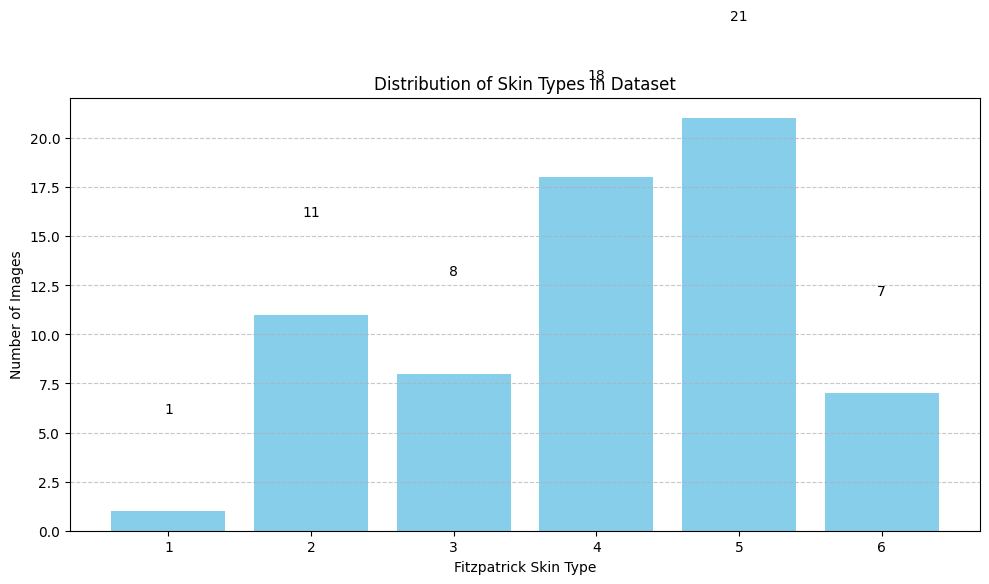

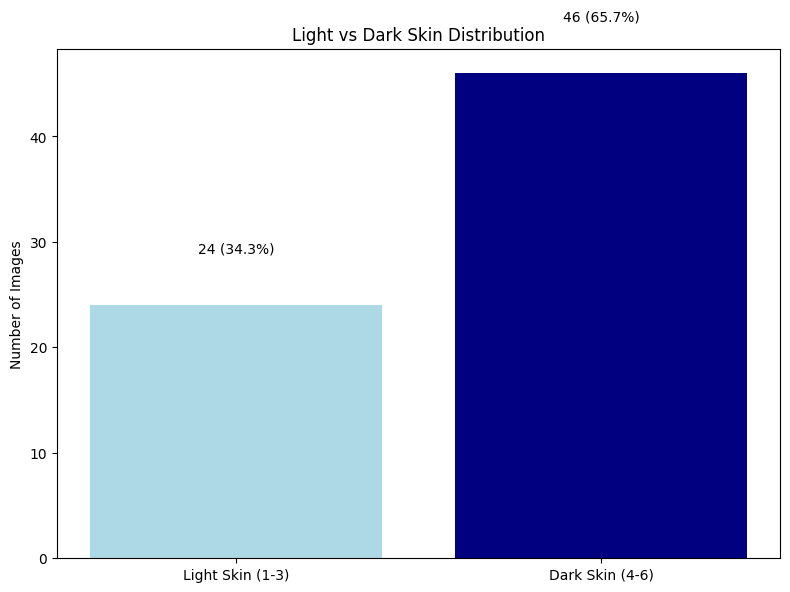

In [20]:
def visualize_dataset_distribution(dataset):
    """
    Visualize the distribution of skin types in the dataset
    """
    # Extract skin types from dataset
    if isinstance(dataset, torch.utils.data.Subset):
        # If it's a subset, get the original dataset
        original_dataset = dataset.dataset
        skin_types = [original_dataset.data_frame.iloc[i]['fitzpatrick_scale'] for i in dataset.indices]
    else:
        skin_types = dataset.data_frame['fitzpatrick_scale'].values
    
    # Count occurrences of each skin type
    skin_type_counts = {}
    for i in range(1, 7):
        skin_type_counts[i] = sum(skin_types == i)
    
    # Create bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(skin_type_counts.keys(), skin_type_counts.values(), color='skyblue')
    plt.xlabel('Fitzpatrick Skin Type')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Skin Types in Dataset')
    plt.xticks(range(1, 7))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add text labels on top of each bar
    for i, count in skin_type_counts.items():
        plt.text(i, count + 5, str(count), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Also show light vs dark distribution
    light_count = sum(st <= 3 for st in skin_types)
    dark_count = sum(st >= 4 for st in skin_types)
    
    plt.figure(figsize=(8, 6))
    plt.bar(['Light Skin (1-3)', 'Dark Skin (4-6)'], [light_count, dark_count], color=['lightblue', 'navy'])
    plt.ylabel('Number of Images')
    plt.title('Light vs Dark Skin Distribution')
    
    # Add percentage labels
    total = light_count + dark_count
    plt.text(0, light_count + 5, f"{light_count} ({light_count/total:.1%})", ha='center')
    plt.text(1, dark_count + 5, f"{dark_count} ({dark_count/total:.1%})", ha='center')
    
    plt.tight_layout()
    plt.show()

# Usage
train_dataset = FitzpatrickDataset(
    csv_file=os.path.join(DATA_PATH, 'train_split.csv'),
    root_dir=DATA_PATH,
    transform=None,
    target_condition=['psoriasis', 'squamous_cell_carcinoma', 'lichen_planus']
)
visualize_dataset_distribution(train_dataset)


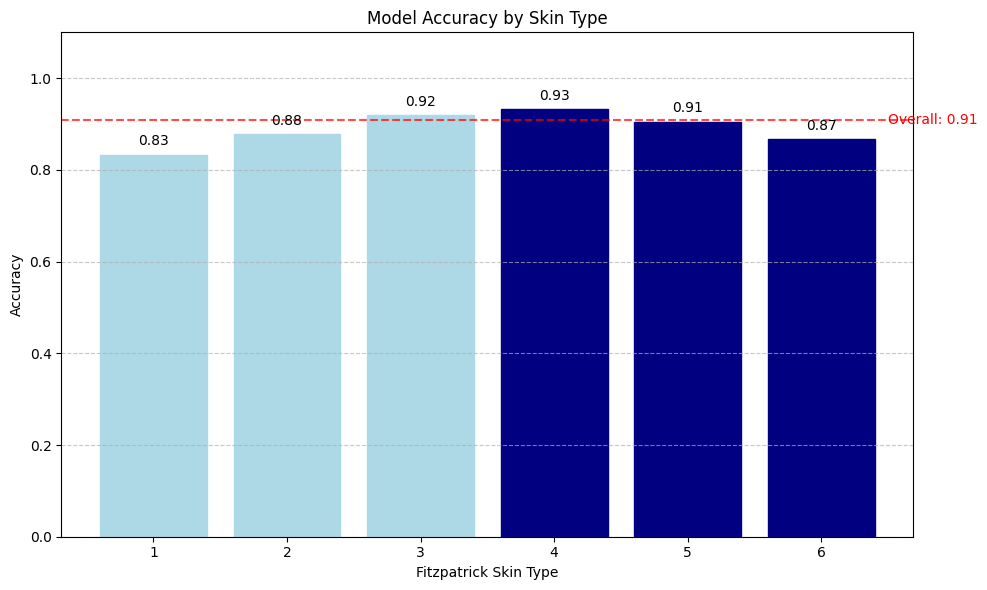

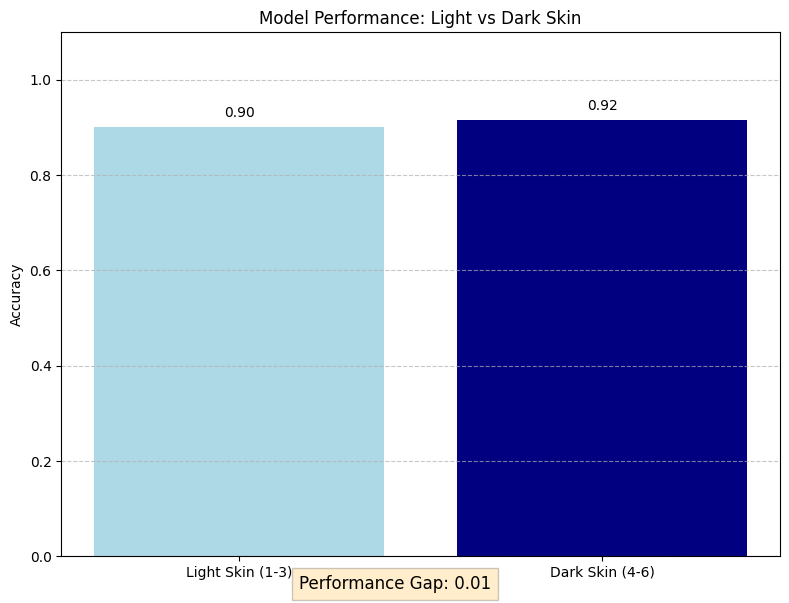

In [21]:
def visualize_performance_by_skin_type(metrics):
    """
    Visualize model performance across different skin types
    """
    # Extract accuracy by skin type
    skin_types = list(range(1, 7))
    accuracies = []
    
    for st in skin_types:
        if st in metrics['skin_type_metrics']:
            accuracies.append(metrics['skin_type_metrics'][st])
        else:
            accuracies.append(0)  # No data for this skin type
    
    # Create bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(skin_types, accuracies, color='lightgreen')
    
    # Color bars differently based on skin type group
    for i, bar in enumerate(bars):
        if i < 3:  # Light skin (types 1-3)
            bar.set_color('lightblue')
        else:  # Dark skin (types 4-6)
            bar.set_color('navy')
    
    plt.xlabel('Fitzpatrick Skin Type')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy by Skin Type')
    plt.xticks(skin_types)
    plt.ylim(0, 1.1)  # Set y-axis from 0 to 1.1 for better visualization
    
    # Add text labels on top of each bar
    for i, acc in enumerate(accuracies):
        if acc > 0:  # Only add label if there's data
            plt.text(i+1, acc + 0.02, f"{acc:.2f}", ha='center')
    
    # Add horizontal line for overall accuracy
    plt.axhline(y=metrics['overall_accuracy'], color='red', linestyle='--', alpha=0.7)
    plt.text(6.5, metrics['overall_accuracy'], f"Overall: {metrics['overall_accuracy']:.2f}", 
             va='center', ha='left', color='red')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Create light vs dark comparison
    plt.figure(figsize=(8, 6))
    plt.bar(['Light Skin (1-3)', 'Dark Skin (4-6)'], 
            [metrics['light_skin_accuracy'], metrics['dark_skin_accuracy']], 
            color=['lightblue', 'navy'])
    plt.ylabel('Accuracy')
    plt.title('Model Performance: Light vs Dark Skin')
    plt.ylim(0, 1.1)
    
    # Add text labels on top of each bar
    plt.text(0, metrics['light_skin_accuracy'] + 0.02, 
             f"{metrics['light_skin_accuracy']:.2f}", ha='center')
    plt.text(1, metrics['dark_skin_accuracy'] + 0.02, 
             f"{metrics['dark_skin_accuracy']:.2f}", ha='center')
    
    # Calculate and display the gap
    gap = abs(metrics['light_skin_accuracy'] - metrics['dark_skin_accuracy'])
    plt.figtext(0.5, 0.01, f"Performance Gap: {gap:.2f}", ha='center', 
                fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Usage (after training and evaluation)
# metrics = validate_model_across_skin_types(model, test_loader, device)
visualize_performance_by_skin_type(metrics)


In [22]:
# Confusion Matrix Visualization
def plot_confusion_matrix(metrics, class_names=None):
    """
    Plot a styled confusion matrix
    """
    cm = metrics['confusion_matrix']
    
    if class_names is None:
        if cm.shape[0] == 2:
            class_names = ['Non-Malignant', 'Malignant']
        else:
            class_names = [f'Class {i}' for i in range(cm.shape[0])]
    
    plt.figure(figsize=(10, 8))
    
    # Create a custom colormap from white to blue
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    # Plot the confusion matrix with percentages
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    # Add accuracy in the corner
    plt.figtext(0.5, 0.01, f"Overall Accuracy: {metrics['overall_accuracy']:.2f}", 
                ha='center', fontsize=12, 
                bbox={"facecolor":"lightgreen", "alpha":0.5, "pad":5})
    
    plt.tight_layout()
    plt.show()

# Usage
plot_confusion_matrix(metrics)


KeyError: 'confusion_matrix'